Import all the needed libraries.

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors

plt.rcParams.update({'text.usetex' : True,
          'font.size': 16,
          "font.family": "sans-serif",
          "font.sans-serif": "Helvetica",
          'figure.figsize': (6.4,4)})

Variables for running the notebook.

In [3]:
METRIC="accuracy"
DATASETS=["EDGE2022", "ICS-D1", "CICIDS2017"]
GREEDY_STRATEGY="sequential_backward_elimination"
EVALUATION_ALGORITHM="custom"
REMAINING_APPROACH="random"
ALL_PRUNE_ALG = ["globally_connections_l1", "globally_connections_random", "locally_connections_l1", "locally_neurons_l1"]
PRUNE_AMOUNT=[]

SUBSETS_SIZE_AMOUNTS=[0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
BEST_FEATURES_FOR_SUBSET_AMOUNTS=[0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
MODEL_PRUNING_AMOUNTS=[0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]

AUTOML_DIRECTORY="../../datasets/{dataset}/balanced/automl_search"
BEST_MODEL_DIRECTORY=f"{AUTOML_DIRECTORY}/models/best_model"
GREEDY_RANK_DIRECTORY=f"{BEST_MODEL_DIRECTORY}/feature_ranking_{GREEDY_STRATEGY}_{EVALUATION_ALGORITHM}"
FEATURE_SUBSETS_DIRECTORY=f"{GREEDY_RANK_DIRECTORY}/feature_subset_stochastic_search_{REMAINING_APPROACH}"
PRUNED_MODELS_DIRECTORY=f"{BEST_MODEL_DIRECTORY}/prune_search/" + "{prune_algorithm}"

## EDGE2022

In [4]:
datas = {}
for dataset in DATASETS:
    datas[dataset] = {"baseline": pd.read_csv(f"{BEST_MODEL_DIRECTORY}/leaderboard.csv".format(dataset=dataset), index_col="ID")}
    datas[dataset]["baseline_general"] = datas[dataset]["baseline"].loc["finetune"][METRIC],
    datas[dataset]["greedy"] = pd.read_csv(f"{GREEDY_RANK_DIRECTORY}/leaderboard.csv".format(dataset=dataset), index_col="ID")
    datas[dataset]["max_features"] = datas[dataset]["greedy"].index.values[0]
    datas[dataset]["baselines_at_ranks"] = [datas[dataset]["greedy"].loc[round(k*datas[dataset]["max_features"]) or 1][METRIC] for k in SUBSETS_SIZE_AMOUNTS]

Chart #1: creating the feature ranking chart obtained via the RFE (Greedy) approach.

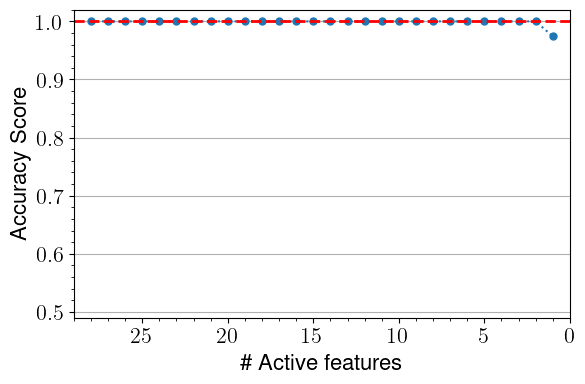

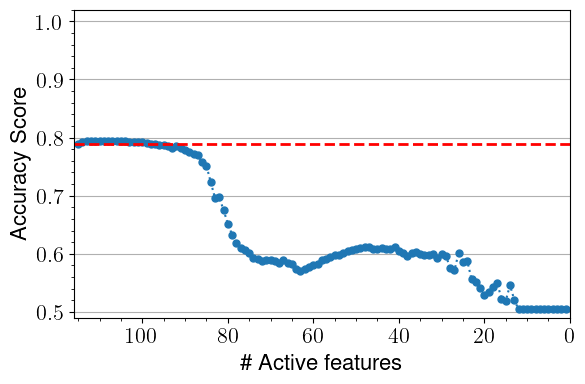

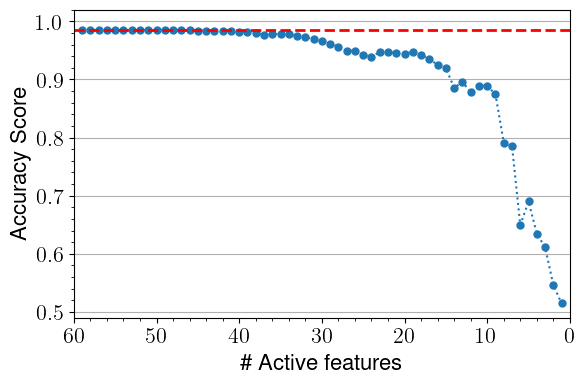

In [6]:
for dataset in DATASETS:
    df = pd.read_csv(f"{GREEDY_RANK_DIRECTORY}/leaderboard.csv".format(dataset=dataset), index_col="ID")
    df["ID"] = df.index.values
    fig, ax = plt.subplots()
    df.plot(x="ID",y=METRIC, xlabel='\# Active features', ylabel="Accuracy Score", ax=ax, alpha=1, style="o:", label="", markersize=5)
    ax.set_ylim(0, 1.05)
    ax.hlines(y = datas[dataset]["baseline_general"], xmin=df.ID.min()-1, xmax=df.ID.max()+1, color = 'r', linestyle = '--', label="Baseline", linewidth=2)
    ax.set_ylim(top=1.02, bottom=0.49)
    ax.set_xlim(right=df.ID.max()+1, left=df.ID.min()-1)
    ax.invert_xaxis()
    ax.minorticks_on()
    ax.grid(axis="y")
    ax.legend(loc="lower left")
    figg = plt.figure()
    figg.legend(*ax.get_legend_handles_labels(), loc="center", bbox_to_anchor=(0.5, 1.13), ncols=2)
    figg.savefig(f"{GREEDY_RANK_DIRECTORY}/legendgreedy.pdf".format(dataset=dataset), bbox_inches="tight")
    plt.close(figg)    
    ax.get_legend().set_visible(False)
    fig.savefig(f"{GREEDY_RANK_DIRECTORY}/leaderboard_{METRIC}.pdf".format(dataset=dataset), bbox_inches="tight")
    display(fig)
    plt.close(fig)

Chart #2: Creating the leaderboard of the subsets measured on the baseline model (no pruning yet)

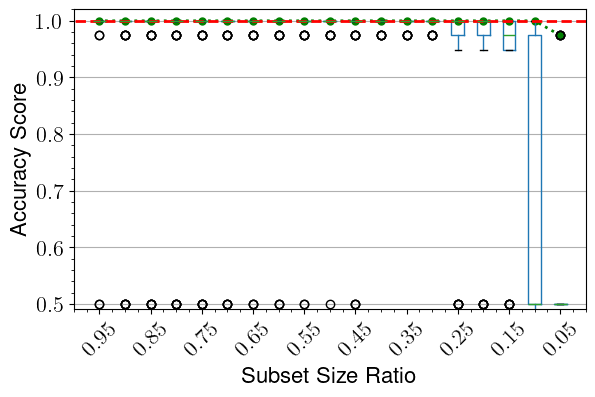

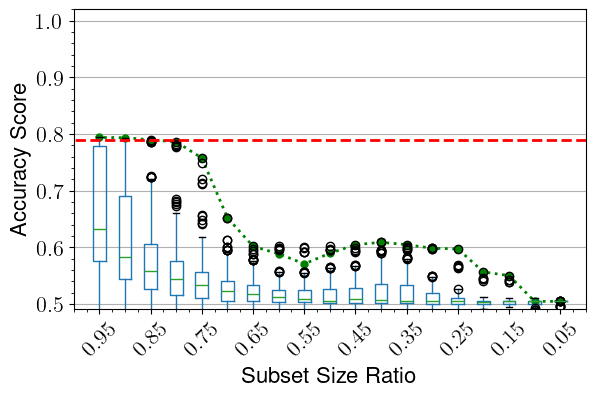

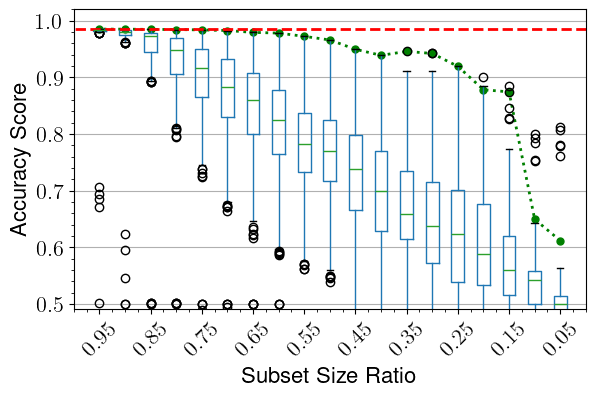

In [8]:
for dataset in DATASETS:
    df = pd.DataFrame()
    for x in SUBSETS_SIZE_AMOUNTS:
        tmp = pd.read_csv(f"{FEATURE_SUBSETS_DIRECTORY}/feature_subsets_{x:.2f}s/leaderboard.csv".format(dataset=dataset), index_col="ID")
        tmp.loc[len(tmp)] = datas[dataset]["greedy"].loc[round(x*datas[dataset]["max_features"]) or 1]
        tmp['kind'] = f"{x:.2f}"
        df = pd.concat((df, tmp))

    df.sort_values('kind', inplace=True, ascending=False)

    fig, ax = plt.subplots()

    ax.plot(range(1, 1+ len(df.kind.unique())), datas[dataset]["baselines_at_ranks"], color='g', linestyle = ':', label="Baseline RFE", linewidth=2, marker="o", markersize=5)

    bp = df.boxplot(column=METRIC, by="kind", ax=ax, ylabel=f"{METRIC.capitalize()} Score", xlabel="Subset Size Ratio", return_type='both')
    for xx in bp:
        for fly in xx[1]['fliers']:
            fdata = fly.get_data()
            tmp2 = []
            for x in fdata:
                if len(x) < 1:
                    tmp2.append([None, None])
                    continue
                x = list(sorted(x))
                tmp2.append(x[:5] + x[-5:])
            fly.set_data(tmp2)
    ax.invert_xaxis()
    ax.set_ylim(top=1.02, bottom=0.49)
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23])
    ax.minorticks_on()
    ax.set_xticklabels([f'$\\mathdefault{x.get_text()}$' for x in ax.get_xticklabels()], rotation=45)
    ax.grid(axis="x")
    ax.hlines(y = datas[dataset]["baseline_general"], xmin=0, xmax=1+len(df.kind.unique()), color = 'r', linestyle = '--', label="Baseline", linewidth=2)
    ax.set_xlim(left=1+len(df.kind.unique()), right=0)
    ax.legend(loc="center", bbox_to_anchor=(0.5, 1.13), ncols=2)
    fig.suptitle("")
    ax.set_title("")
    figg = plt.figure()
    figg.legend(*ax.get_legend_handles_labels(), loc="center", bbox_to_anchor=(0.5, 1.13), ncols=2)
    figg.savefig(f"{FEATURE_SUBSETS_DIRECTORY}/legendss.pdf".format(dataset=dataset), bbox_inches="tight")
    plt.close(figg)    
    ax.get_legend().set_visible(False)
    fig.savefig(f"{FEATURE_SUBSETS_DIRECTORY}/leaderboard_{METRIC}.pdf".format(dataset=dataset), bbox_inches="tight")

## Leaderboard per pruning algorithm nel subset

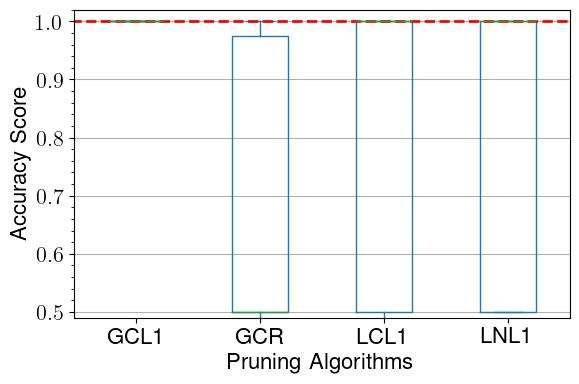

<Figure size 640x400 with 0 Axes>

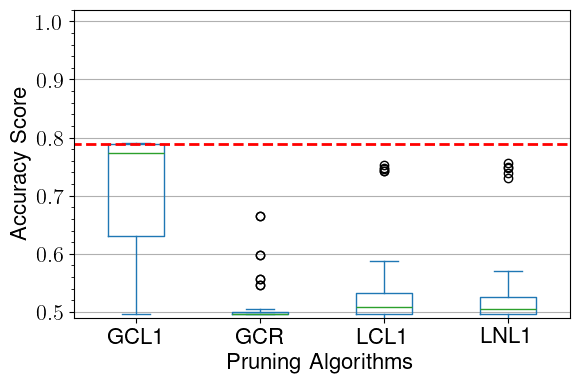

<Figure size 640x400 with 0 Axes>

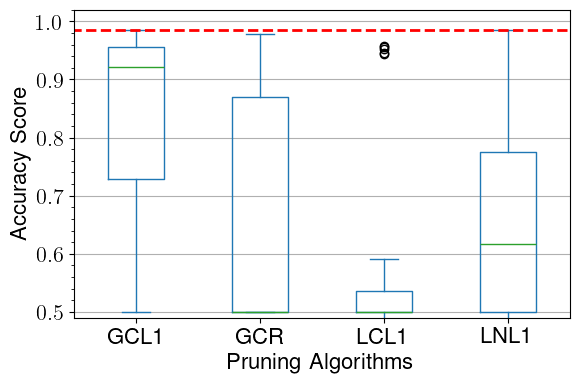

<Figure size 640x400 with 0 Axes>

In [76]:
for dataset in DATASETS:
    df = pd.DataFrame()
    for x in ALL_PRUNE_ALG:
        tmp = pd.read_csv(f"{BEST_MODEL_DIRECTORY}/prune_search/{x}/leaderboard.csv".format(dataset=dataset), index_col="ID")
        tmp['kind'] = "".join([x[0] if len(x) > 2 else x for x in x.split("_")]).upper()
        df = pd.concat((df, tmp))
    df.sort_values('kind', inplace=True, ascending=False)
    kinds = df.kind.unique()

    fig, ax = plt.subplots()
    bp = df.plot.box(column=METRIC, by="kind", ax=ax, return_type='both', ylabel=f"{METRIC.capitalize()} Score", xlabel="Pruning Algorithms")#, boxprops={"linewidth": 2}, whiskerprops={"linewidth": 2})
    for xx in bp:
        for fly in xx[1]['fliers']:
            fdata = fly.get_data()
            tmp2 = []
            for x in fdata:
                if len(x) < 1:
                    tmp2.append([None, None])
                    continue
                x = list(sorted(x))
                tmp2.append(x[:5] + x[-5:])
            fly.set_data(tmp2)
    ax.set_ylim(top=1.02, bottom=0.49)
    ax.grid(axis="y")
    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)

    ax.hlines(y = datas[dataset]["baseline_general"], xmin=0, xmax=1+len(df.kind.unique()), color = 'r', linestyle = '--', label="Baseline", linewidth=2)
    ax.set_xlim(left=0.5, right=4.5)
    ax.legend(loc="center", bbox_to_anchor=(0.5, 1.13), ncols=1)
    figg = plt.figure()
    figg.legend(*ax.get_legend_handles_labels(), loc="center", bbox_to_anchor=(0.5, 1.13), ncols=1)
    figg.savefig(f"{BEST_MODEL_DIRECTORY}/prune_search/legendd.pdf".format(dataset=dataset), bbox_inches="tight")
    ax.get_legend().set_visible(False)    
    ax.set_title("")
    fig.savefig(f"{BEST_MODEL_DIRECTORY}/prune_search/pruning_algorithms.pdf".format(dataset=dataset), bbox_inches="tight")

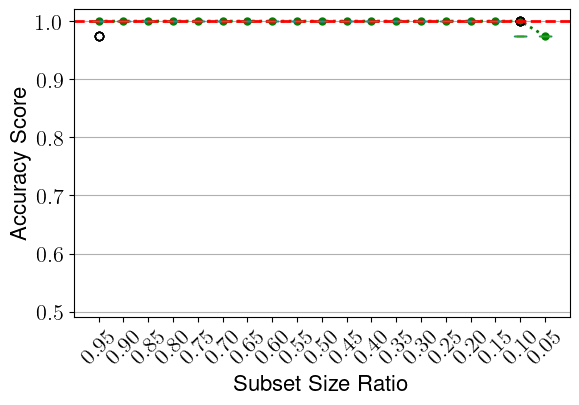

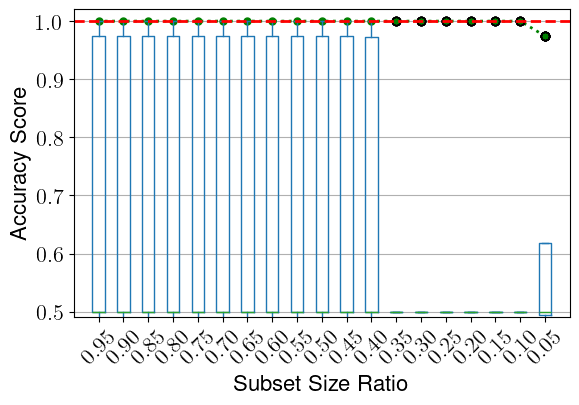

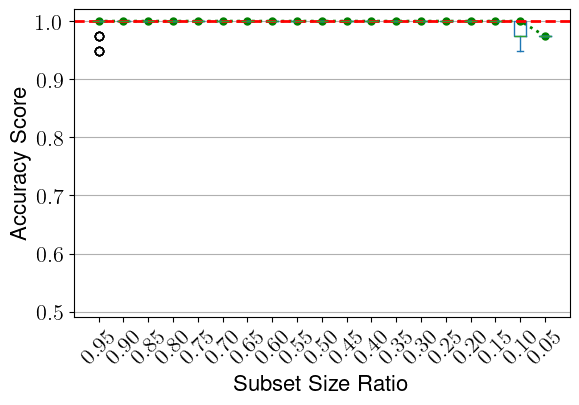

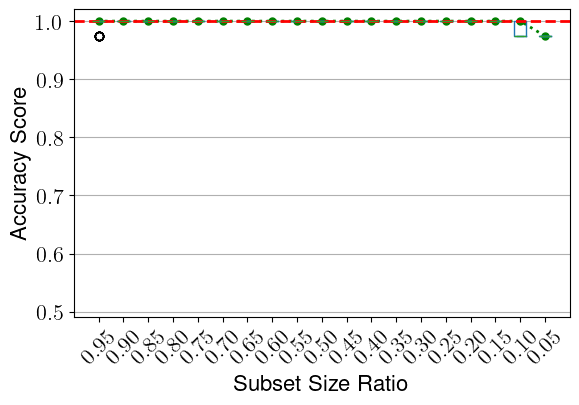

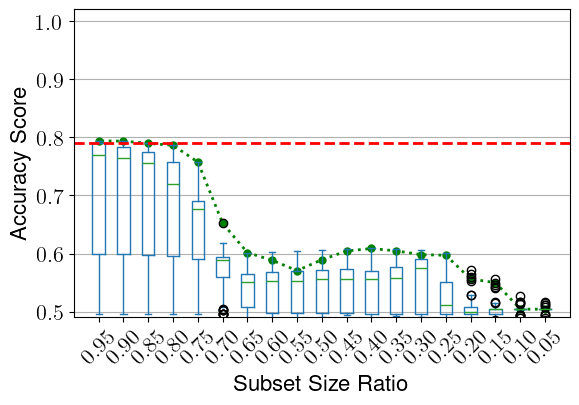

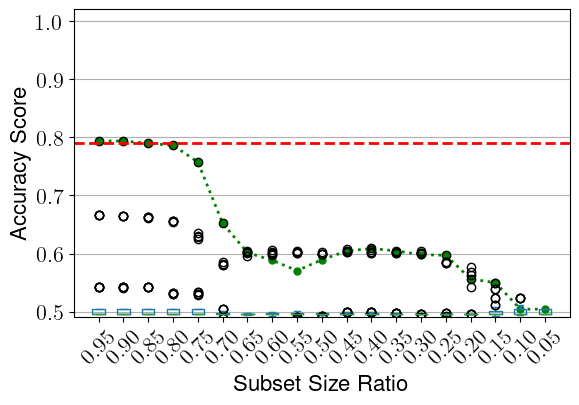

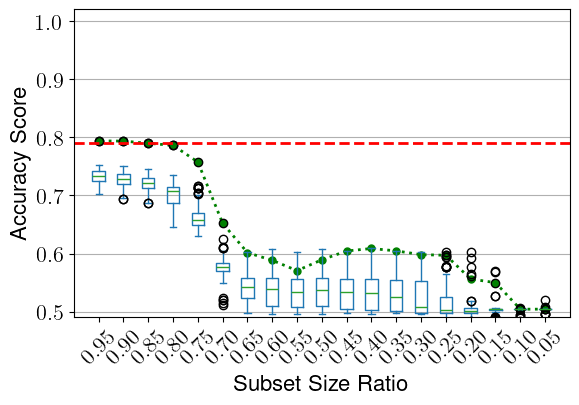

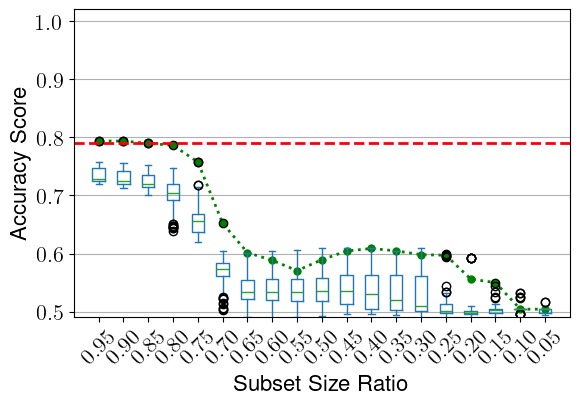

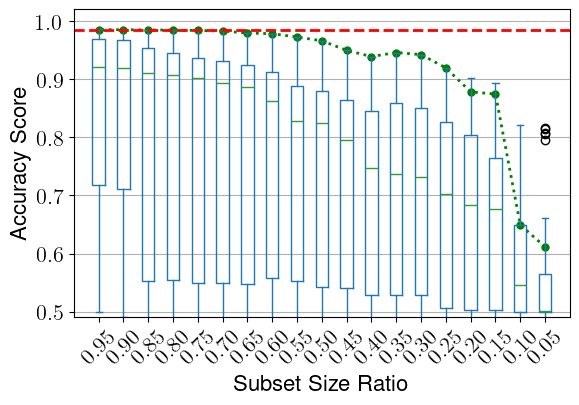

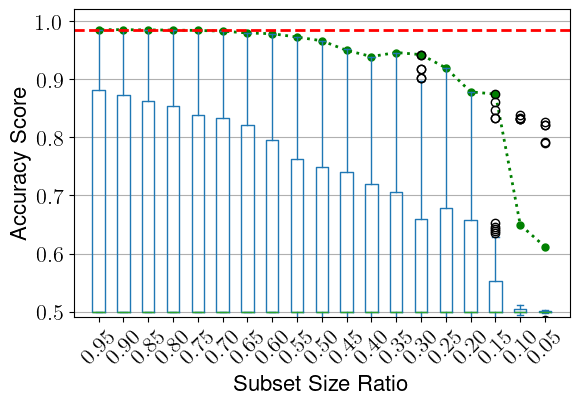

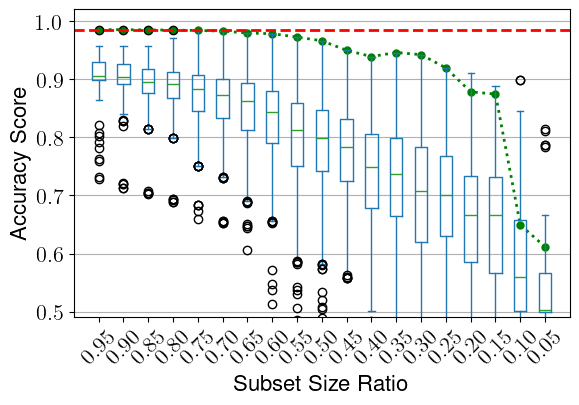

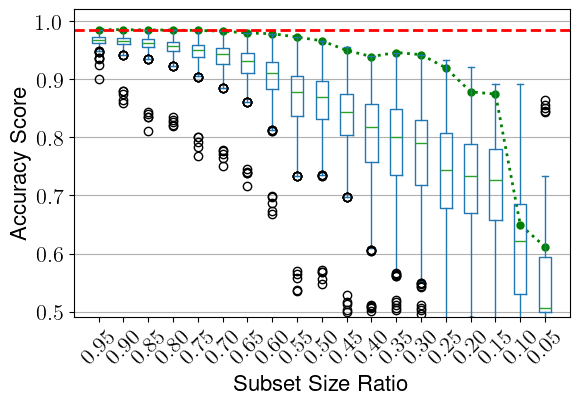

In [94]:
for dataset in DATASETS:
    for prune_algorithm in ALL_PRUNE_ALG:
        df = pd.DataFrame()
        for x in SUBSETS_SIZE_AMOUNTS:
            tmp = pd.read_csv(f"{FEATURE_SUBSETS_DIRECTORY}/feature_subsets_{x:.2f}s/leaderboard_{prune_algorithm}.csv".format(dataset=dataset), index_col="ID")
            tmp.loc[len(tmp)] = datas[dataset]["greedy"].loc[round(x*datas[dataset]["max_features"]) or 1]
            tmp['kind'] = f"{x:.2f}"
            df = pd.concat((df, tmp))

        fig, ax = plt.subplots()

        ax.plot(range(1, 1+ len(df.kind.unique())), datas[dataset]["baselines_at_ranks"], color='g', linestyle=":", marker="o", label="Baseline RFE", linewidth=2, markersize=5)

        bp = df.plot.box(column=METRIC, by="kind", ax=ax, return_type='both', ylabel=f"{METRIC.capitalize()} Score", xlabel="Subset Size Ratio")
        for xx in bp:
            for fly in xx[1]['fliers']:
                fdata = fly.get_data()
                tmp2 = []
                for x in fdata:
                    if len(x) < 1:
                        tmp2.append([None, None])
                        continue
                    x = list(sorted(x))
                    tmp2.append(x[:5] + x[-5:])
                fly.set_data(tmp2)
        ax.invert_xaxis()
        ax.set_xticklabels([f'$\\mathdefault{x.get_text()}$' for x in ax.get_xticklabels()], rotation=45)
        ax.set_ylim(top=1.02, bottom=0.49)
        ax.grid(axis="y")
        ax.set_xlim(left=1+len(df.kind.unique()), right=0)
        ax.set_title("")
        ax.hlines(y = datas[dataset]["baseline_general"], xmin=0, xmax=1+len(df.kind.unique()), color = 'r', linestyle = '--', label="Baseline", linewidth=2)
        ax.legend(loc="center", bbox_to_anchor=(0.5, 1.13), ncols=2)
        figg = plt.figure()
        figg.legend(*ax.get_legend_handles_labels(), loc="center", bbox_to_anchor=(0.5, 1.13), ncols=2)
        figg.savefig(f"{FEATURE_SUBSETS_DIRECTORY}/legenddd.pdf".format(dataset=dataset), bbox_inches="tight")
        plt.close(figg)
        ax.get_legend().set_visible(False)
        fig.savefig(f"{FEATURE_SUBSETS_DIRECTORY}/leaderboard_{METRIC}_{prune_algorithm}.pdf".format(dataset=dataset), bbox_inches="tight")
        display(fig)
        plt.close(fig)

In [95]:
all_score_with_pruning_amounts = {}
for dataset in DATASETS:
    for prune_algorithm in ALL_PRUNE_ALG:
        df = pd.DataFrame()
        for x in SUBSETS_SIZE_AMOUNTS:
            tmp = pd.read_csv(f"{FEATURE_SUBSETS_DIRECTORY}/feature_subsets_{x:.2f}s/leaderboard_{prune_algorithm}.csv".format(dataset=dataset), index_col="ID")
            tmp['kind'] = f"{x:.2f}"
            df = pd.concat((df, tmp))
        df.sort_values('kind', inplace=True, ascending=False)
        kinds = df.kind.unique()

        models_stats = pd.read_csv(f"{PRUNED_MODELS_DIRECTORY}/models_stats.csv".format(dataset=dataset, prune_algorithm=prune_algorithm), index_col="ID")
        score_with_pruning_amounts = df.join(models_stats, on="model_ID", how='left')
        if "locally_" in prune_algorithm:
            import ast
            score_with_pruning_amounts["amount"] = score_with_pruning_amounts["amount"].apply(lambda x: round(sum(x for x in ast.literal_eval(x))/len(ast.literal_eval(x)), 2))
        all_score_with_pruning_amounts[(dataset, prune_algorithm)] = score_with_pruning_amounts

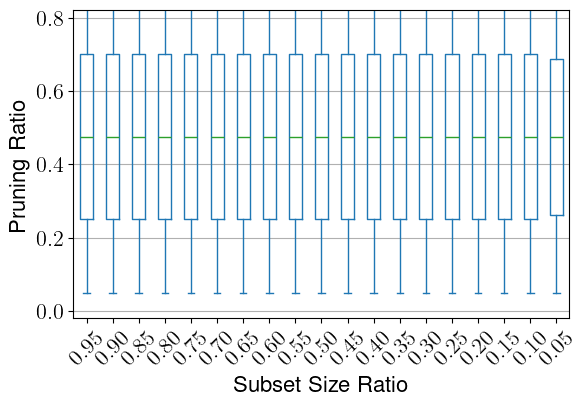

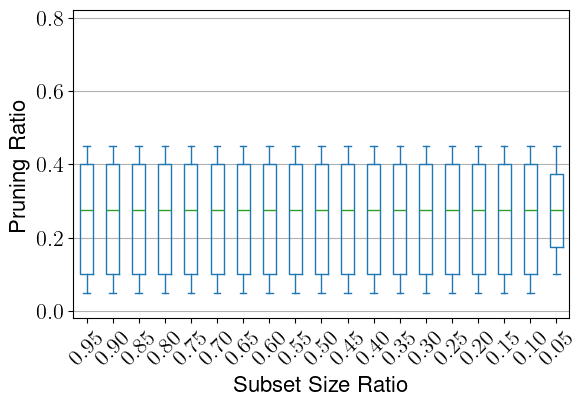

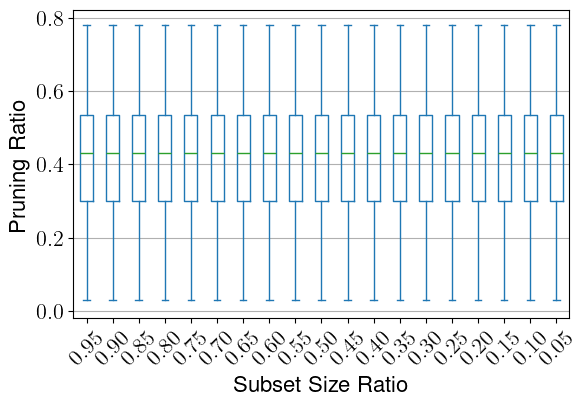

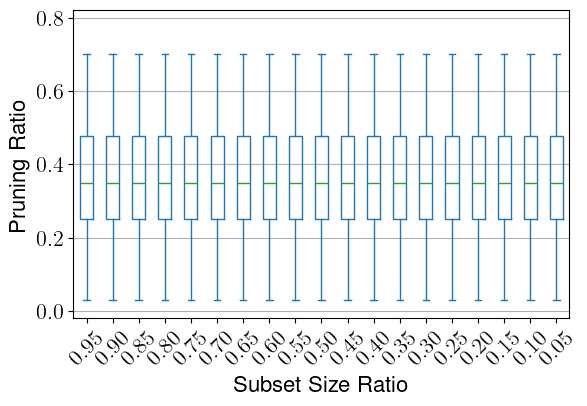

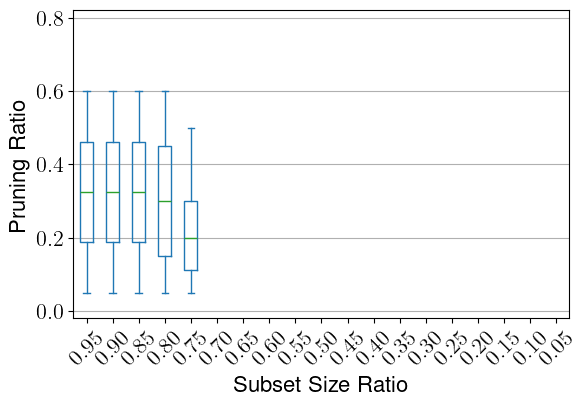

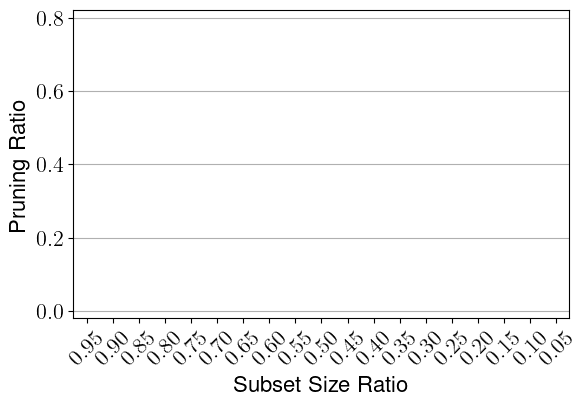

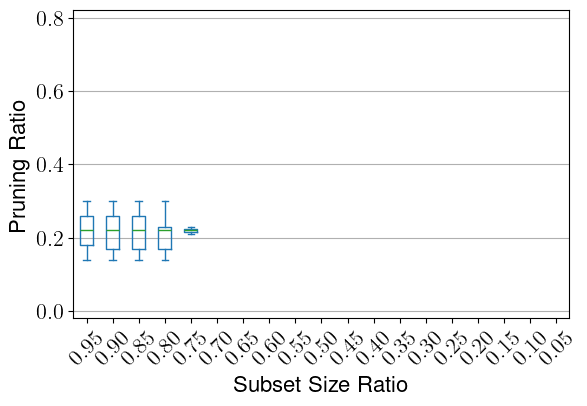

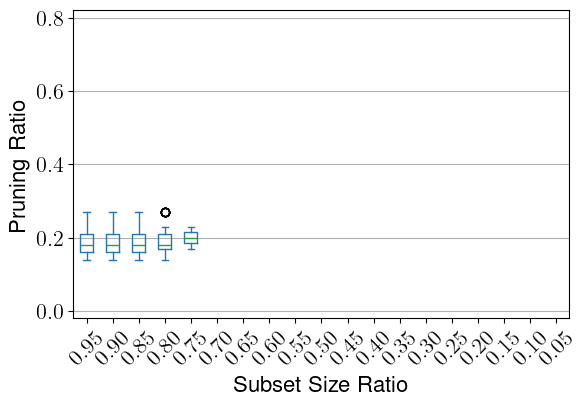

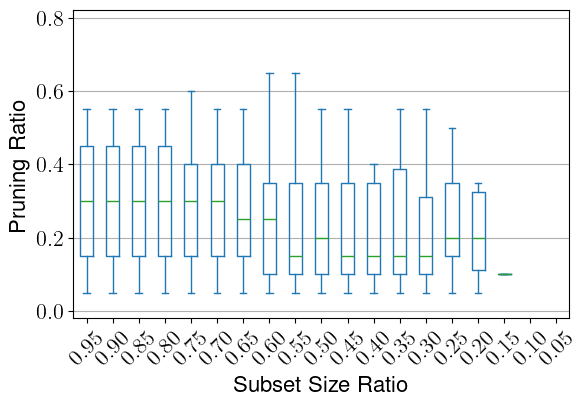

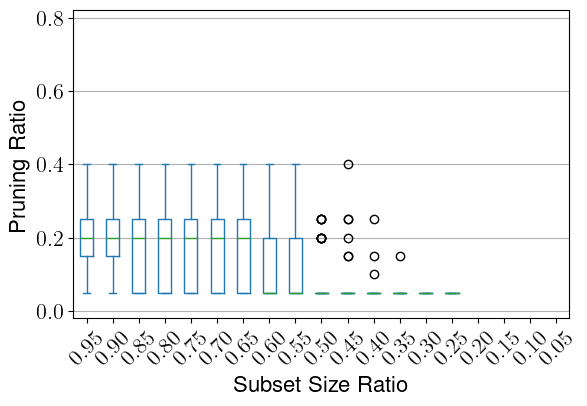

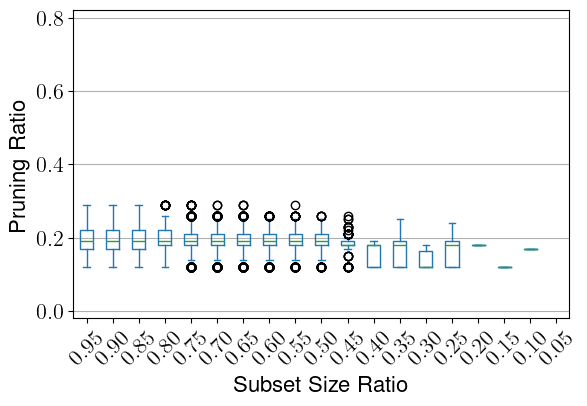

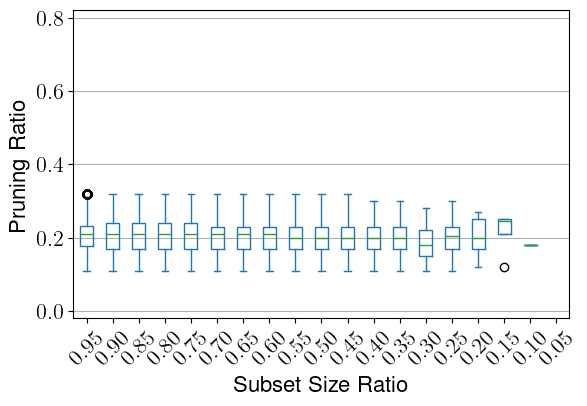

In [96]:
for dataset in DATASETS:
    for prune_algorithm in ALL_PRUNE_ALG:
        dff = all_score_with_pruning_amounts[(dataset, prune_algorithm)].copy(deep=True)
        dff.loc[dff["degradation_full_baseline"] > 0.10, "amount"] = None
        fig, ax = plt.subplots()
        bp = dff.plot.box(column="amount", by="kind", ax=ax, return_type='both', ylabel="Pruning Ratio", xlabel="Subset Size Ratio")
        ax.invert_xaxis()
        ax.set_ylim(top=0.82, bottom=-0.02)
        ax.grid(axis="y")
        ax.set_title("")
        ax.set_xticklabels([f'$\\mathdefault{x.get_text()}$' for x in ax.get_xticklabels()], rotation=45)
        fig.savefig(f"{FEATURE_SUBSETS_DIRECTORY}/subsets_pruning_below_10_degradation_{METRIC}_{prune_algorithm}.pdf".format(dataset=dataset), bbox_inches="tight")
        display(fig)
        plt.close(fig)

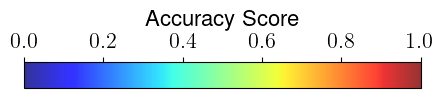

EDGE2022 globally_connections_l1


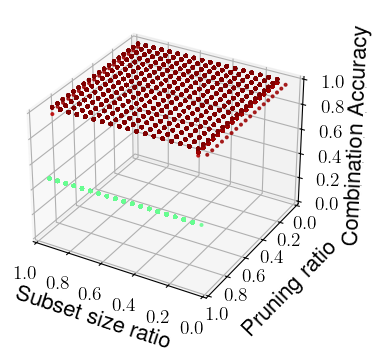

EDGE2022 globally_connections_random


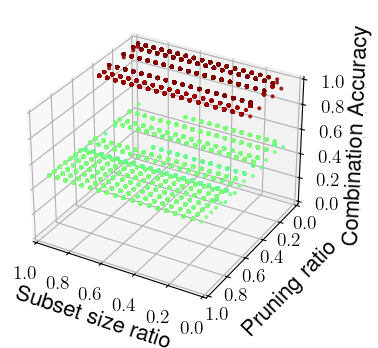

EDGE2022 locally_connections_l1


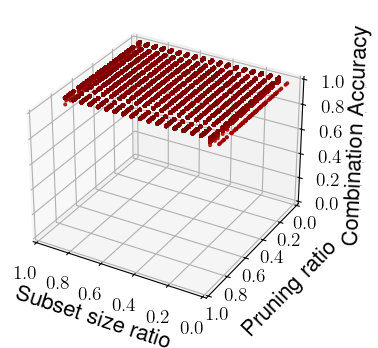

EDGE2022 locally_neurons_l1


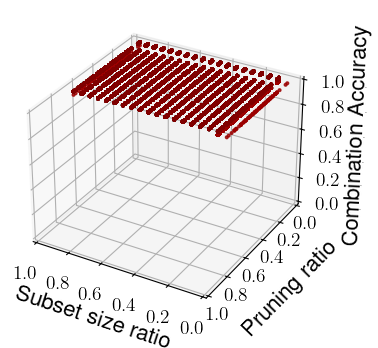

ICS-D1 globally_connections_l1


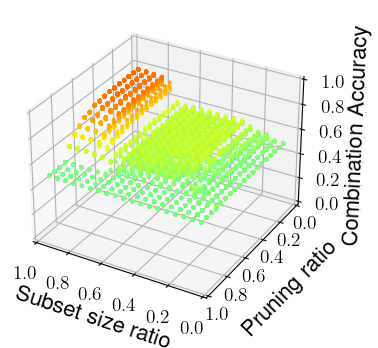

ICS-D1 globally_connections_random


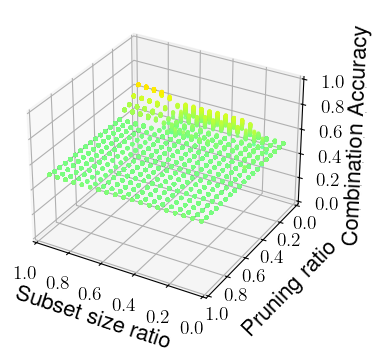

ICS-D1 locally_connections_l1


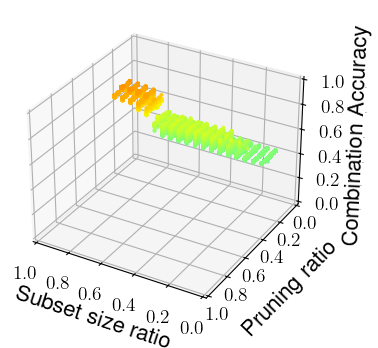

ICS-D1 locally_neurons_l1


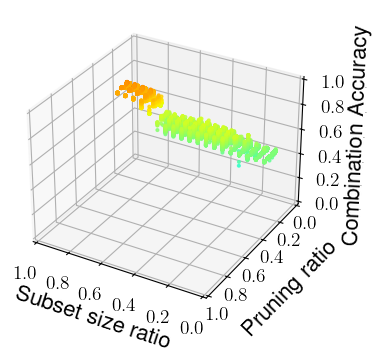

CICIDS2017 globally_connections_l1


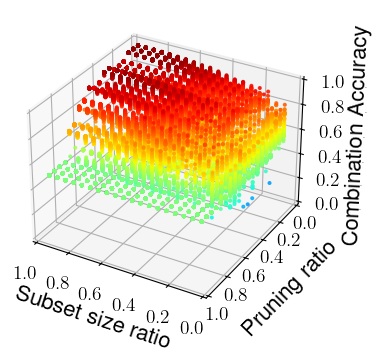

CICIDS2017 globally_connections_random


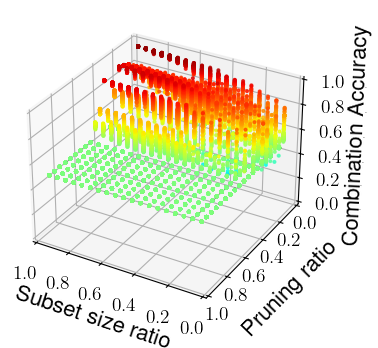

CICIDS2017 locally_connections_l1


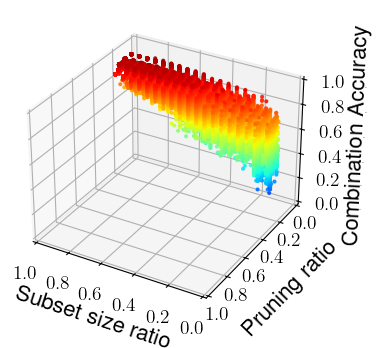

CICIDS2017 locally_neurons_l1


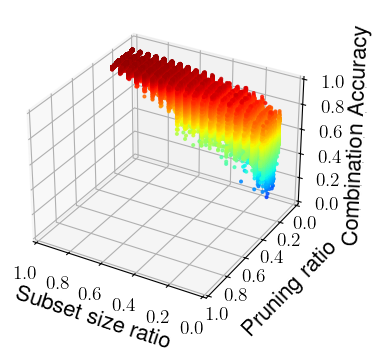

In [97]:
for dataset in DATASETS:
    for prune_algorithm in ALL_PRUNE_ALG:
        sorted_by_index = all_score_with_pruning_amounts[(dataset, prune_algorithm)].sort_index(ascending=False)
        sorted_by_index['kind'] = pd.to_numeric(sorted_by_index['kind'])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')


        norm = colors.Normalize(vmin=0, vmax=1)
        sctt = ax.scatter3D(sorted_by_index["kind"], sorted_by_index["amount"], sorted_by_index[METRIC],
                            alpha = 0.8,
                            s=15,
                            c = sorted_by_index[METRIC],
                            cmap = cm.jet,
                            norm=norm,
                            marker ='.', rasterized=True)
        
        figg,axee = plt.subplots()
        figg.colorbar(sctt, ax=axee, label=f"{METRIC.capitalize()} Score", shrink = 0.8, aspect = 15, pad=0.11, location="top")
        axee.remove()
        figg.savefig(f"{FEATURE_SUBSETS_DIRECTORY}/3d_2_legend.pdf".format(dataset=dataset), bbox_inches="tight")
        display(figg)
        plt.close(figg)

        ax.tick_params(axis='y', which='major', pad=-2, labelsize=14)
        ax.tick_params(axis='x', which='major', labelsize=14)
        ax.tick_params(axis='z', which='major', pad=10, labelsize=14)
        ax.set_zticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_zticklabels([f'{x.get_text()}' + "\\hspace{0.5cm}" + "\\tiny{.}" for x in ax.get_zticklabels()])

        ax.set_facecolor("white")
        ax.view_init(30, -60, 0)
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 1)
        ax.set_zlim(0, 1)
        ax.invert_yaxis()
        ax.tick_params(axis="y", which="minor", left=False, right=False)
        ax.invert_xaxis()
        ax.minorticks_off()

        ax.set_ylabel('Pruning ratio')#, labelpad=-7.2)
        ax.set_xlabel('Subset size ratio')#, labelpad=-7.2)
        ax.set_zlabel(f'Combination Accuracy')#, labelpad=-7.2)
        fig.savefig(f"{FEATURE_SUBSETS_DIRECTORY}/3d_2_{METRIC}_{prune_algorithm}.pdf".format(dataset=dataset), bbox_inches="tight")
        print(dataset, prune_algorithm)
        display(fig)
        plt.close(fig)